<a href="https://colab.research.google.com/github/Jairex22/Google-AI-Burger-picture/blob/main/Te_damos_la_bienvenida_a_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification Report:

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45



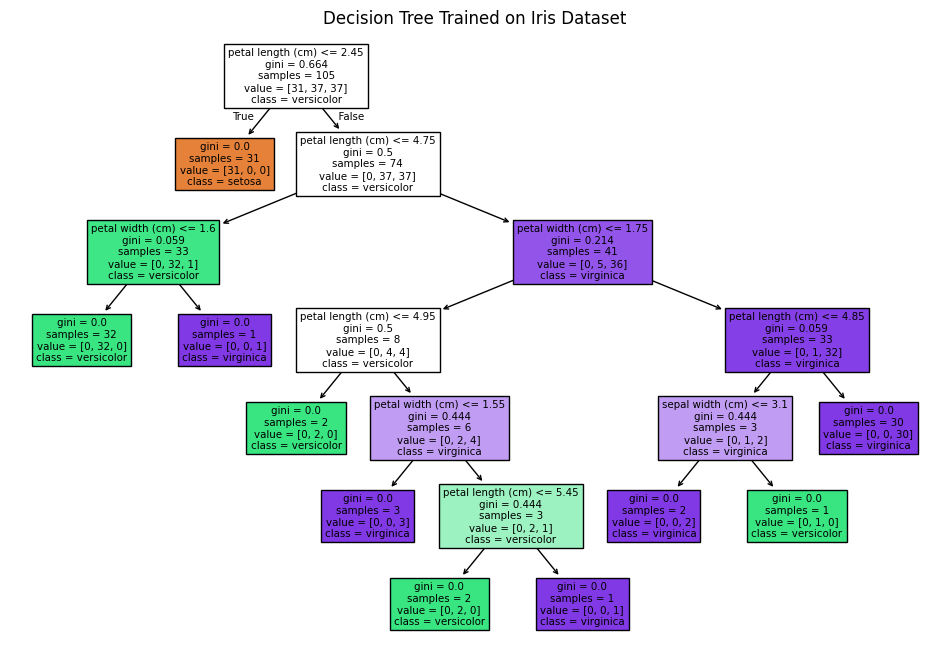

In [94]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Load the Iris dataset
iris = load_iris()
X = iris.data      # Features: sepal length, sepal width, petal length, petal width
y = iris.target    # Labels: 0 = setosa, 1 = versicolor, 2 = virginica

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the decision tree classifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=iris.feature_names, class_names=iris.target_names, filled=True)
plt.title("Decision Tree Trained on Iris Dataset")
plt.show()
